<center><h1>Job web scraping and automatic e-mail sending</h1></center>

<h4>1) Importing the libraries</h4>

The libraries <b>BeautifulSoup</b> and <b>Requests</b> are being used to collect the information from de html source code of the website. <b>Pandas</b> and <b>openpyxl</b> can be used to transform our collected data in a excel spreadsheet and finally, we're gonna send the spreedsheet by e-mail to someone.

In [18]:
from bs4 import BeautifulSoup
from matplotlib import fontconfig_pattern
import requests
import re
import pandas as pd
import openpyxl
import datetime


<h4>2) Getting the Source Code</h4>

Our source is gonna be the brazilian job website called <b>Vagas.com</b>, and the role is 'Data Analyst'. In the website, two filters are applied. One to show first the most recent jobs and the second is to show only jobs related to 'Data Analyst'.

In [19]:
html_text = requests.get('https://www.vagas.com.br/vagas-de-analista-de-dados?m%5B%5D=100%25+Home+Office&ordenar_por=mais_recentes').text
soup = BeautifulSoup(html_text, 'html5lib')


<h4>3) Collecting Information</h4>

The informations that we're gonna collect are: <b>Role</b>, <b>Company</b>, <b>Level</b> and <b>Job Link</b>. After we scrap the data, we're gonna storage in a list to further transform our lists in a <b>DataFrame</b> with pandas. 

Collecting 'Role name' and 'Job link'. The variables are 'lista_cargos' and 'lista_linkvaga' respectively. The list 'site_para_concatenar' will be useful to correct the job link when the data frame is created.

In [20]:
lista_linkvaga = []
lista_cargos = []
site_para_concatenar = []

cargos = soup.find_all('h2', class_ = 'cargo')
for cargo in cargos:
    nome_cargo = cargo.find('a', class_ = "link-detalhes-vaga").text
    link_cargo = cargo.find('a', class_ = "link-detalhes-vaga").get('href')
    lista_cargos.append(nome_cargo.strip())
    lista_linkvaga.append(link_cargo.strip())
    site_para_concatenar.append('vagas.com.br')

Collecting 'Company' and 'Level'. The variables are 'lista_empresas' and 'lista_niveis' respectively.

In [21]:
infos = soup.find_all('div', class_ = 'informacoes-header')

lista_empresas = []
for empresa in infos:
    nome_empresa = empresa.find('span', class_ = 'emprVaga').text.replace(' ','')
    lista_empresas.append(nome_empresa.strip())

lista_niveis = []
for nivel in infos:
    nome_nivel = nivel.find('span', class_ = 'nivelVaga').text.replace(' ','')
    lista_niveis.append(nome_nivel.strip())


<h4>4) Creating a DataFrame</h4>

Alright, we have our four variables storaged in four lists. Now we will transform those lists in a dictionary called 'data' and finally create the DataFrame. the column 'auxiliar' is used concatenate the site domain 'vagas.com' with the link collected from the source code, generating a correct link in the column 'Link para Vaga'. 

In [22]:
data = {'Cargo':lista_cargos,'Empresa':lista_empresas,
'Nivel':lista_niveis,'auxiliar':site_para_concatenar, 'Link':lista_linkvaga}

job_data = pd.DataFrame(data)

job_data['Link para vaga'] = job_data.auxiliar.str.cat(job_data.Link)

job_data.drop('auxiliar', inplace=True, axis = 1)
job_data.drop('Link', inplace=True, axis = 1)

job_data.head()

,Cargo,Empresa,Nivel,Link para vaga
0,Analista de Sistemas Pcd,HMCONSULTORIADERECURSOSHUMANOS,Pleno,vagas.com.br/vagas/v2370855/analista-de-sistem...
1,Analista de Dados III - Business Inteligence,AlgarTelecom,Sênior,vagas.com.br/vagas/v2392052/analista-de-dados-...
2,Analista de Sistemas II (100% Home Office),Orizon,Pleno,vagas.com.br/vagas/v2392229/analista-de-sistem...
3,Analista de Vendas Junior,Philips,Júnior/Trainee,vagas.com.br/vagas/v2390839/analista-de-vendas...
4,Analista Fiscal Pl. São Paulo/sp,InterCementBrasilS.A,Sênior,vagas.com.br/vagas/v2390879/analista-fiscal-pl...



Now that the DataFrame is created, we can save it in a excel spreadsheet using the method to_excel().

In [23]:
arquivo = 'Vagas.xlsx'
job_data.to_excel(arquivo)

<h4>5) Plotting the variable "nível"</h4>

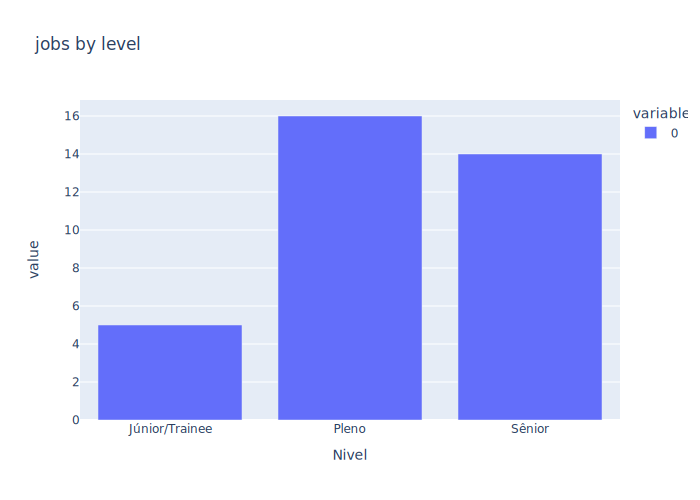

In [24]:
import plotly.express as px
group = job_data.groupby(['Nivel'],as_index=True).size()
fig = px.bar(group, title='jobs by level')
fig.show(renderer="svg")



<h4>6) Sending an e-mail</h4>

Finally, the user will decide if he wants to receive a e-mail with the job spreadsheet. The function 'enviar_email()' takes care of all the parts of an e-mail like Subject, from, to and attachments. For this, the libraries smtplib and EmailMessage are being used. The variable msg will storage the parts of an e-mail, which will be used inside send_message ()

In [25]:
import os
import smtplib
from email.message import EmailMessage

In [26]:
resp = input('Deseja enviar por email?  (s/n) ')

def enviar_email():

    EMAIL_ADRESS = 'lucasazv99@gmail.com'
    EMAIL_PASSWORD = os.environ.get('PythonTest')
    now = datetime.datetime.now()

    msg = EmailMessage()
    msg['Subject'] = f'Vagas Mais Recentes: Analista de Dados - {now}'
    msg['From'] = EMAIL_ADRESS
    msg['To'] = 'lucasazv99@gmail.com'
    msg.set_content( f'Planilha com as Vagas do site Vagas.com atualizado em - {now}')

    files = [arquivo]

    for file in files:
        with open(file, 'rb') as j:
            file_data = j.read()
            file_name = j.name

        msg.add_attachment(file_data, maintype='application', subtype='octet-stream', filename=file_name )

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(EMAIL_ADRESS,EMAIL_PASSWORD)
        smtp.send_message(msg)

if resp == 's':
    enviar_email()
    print('E-mail Enviado com Sucesso!')
else:
    print('E-mail Não Enviado')

E-mail Não Enviado



In this case, I'm sending a e-mail to myself for testing purpose